In [1]:
import os
import sys
import h5py
from pathlib import Path

sys.path.append('../')
from source.computation_support import *
from source.myGaborFunctions import *
from source.color_transformations import *
from source.plot_save_figures import *
from source.graph_operations import *
from source.chameleon import *

from source.color_seg_methods import *
# %matplotlib qt

In [2]:
# Read and show input image
num_cores = -1
source_dir = os.path.abspath('') + '/'
num_imgs = 7

hdf5_indir_im = Path( '../../data/hdf5_datasets/' + str(num_imgs) + 'images/' + 'images')
images_file = h5py.File(hdf5_indir_im / "Berkeley_images.h5", "r+")

all_img_ids = images_file["image_ids"][:]
img_subdirs = images_file["image_subdirs"][:]

test_indices = []

for ii in range(len(all_img_ids)):
    if img_subdirs[ii] == 'test':
        test_indices.append(ii)

In [3]:
# np.where(all_img_ids[test_indices]=='64061')

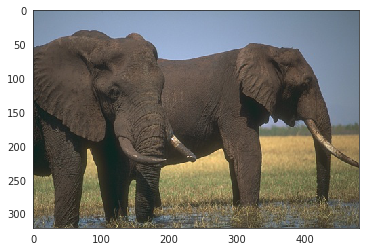

In [4]:
# Read and show input image

img_index = 1 #171 #174 # 10 works good
image_vectors = images_file["images"][test_indices][img_index]
img_shapes = images_file["image_shapes"][test_indices][img_index]

img = image_vectors.reshape(img_shapes)

rows, cols, channels = img.shape
plt.figure()
plt.imshow(img)



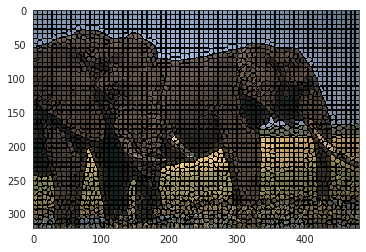

In [5]:
# Read superpixels
n_slic = 500 * 7
hdf5_indir_spix = Path('../../data/hdf5_datasets/' + str(num_imgs) + 'images/' + 'superpixels/' + str(n_slic) + '_slic')
superpixels_file = h5py.File(hdf5_indir_spix / "Berkeley_superpixels.h5", "r+")
superpixels_vectors = superpixels_file["superpixels"][test_indices][img_index]

regions_slic = superpixels_vectors.reshape(rows, cols)
superpixels = segmentation.mark_boundaries(img, regions_slic, color=(0, 0, 0), mode='thick')
superpixels = np.array(superpixels * 255, np.uint8)
plt.imshow(superpixels)


Number of edges: 10774


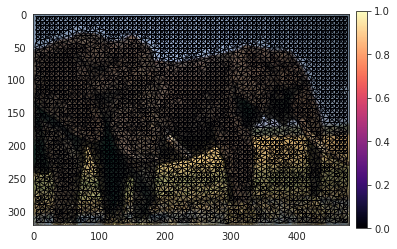

In [6]:
# Generating superpixels graph
graph_type = 'rag'
graph_raw = get_graph(img, regions_slic, graph_type)

lc = graph.show_rag(regions_slic, graph_raw, img, edge_width=1, img_cmap=None, border_color=None)
colbar_lim = (0, 1)
lc.set_clim(colbar_lim[0], colbar_lim[1])
plt.colorbar(lc, fraction=0.0355, pad=0.02)
plt.imshow(img)  


In [7]:
# Reading predicted gradients from h5 files

gradients_dir = 'predicted_gradients'
similarity_measure = 'OT'
learning_method = 'SimpleSum'
gabor_config = '4f_6a_2p_25p_1.00fb_30ab_0.90cpf_0.90cpa_3.0stds'
graph_slic = str(n_slic) + '_slic_' + graph_type + '_' + similarity_measure 


hdf5_indir_grad = Path('../../data/hdf5_datasets/' + str(num_imgs) + 'images/' + gradients_dir + '/' + graph_slic + '/' + learning_method + '/' + gabor_config)
imgs_gradients_file = h5py.File(hdf5_indir_grad / 'predicted_gradients.h5', "r+")
imgs_gradients =  imgs_gradients_file["predicted_gradients"][:]

y_pred = imgs_gradients[img_index]
y_pred_norm = (y_pred - min(y_pred)) / (max(y_pred) - min(y_pred))


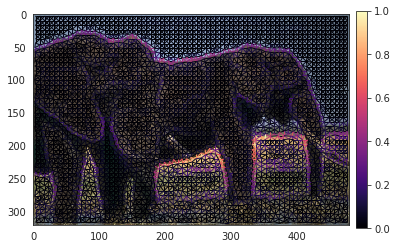

In [8]:
# updating the edge weigths with predicted gradients
graph_weighted = graph_raw.copy()
for i_edge, e in enumerate(list(graph_raw.edges)):
    graph_weighted[e[0]][e[1]]['weight'] = y_pred_norm[i_edge]#
    graph_weighted[e[0]][e[1]]['similarity'] = int(1.0/y_pred[i_edge]* 1e4)
    
graph_weighted.graph['edge_weight_attr'] = 'similarity'

lc = graph.show_rag(regions_slic, graph_weighted, img, edge_width=1, img_cmap=None, border_color=None)
colbar_lim = (min(y_pred_norm), max(y_pred_norm))
lc.set_clim(colbar_lim[0], colbar_lim[1])
plt.colorbar(lc, fraction=0.0355, pad=0.02)
plt.imshow(img) 

Max edge weight: 1.0 Min edge weight: 0.0
(1.1392263790481088, -0.00017724356309004925, 0.025362038104791082)
Threshold: 0.04591590835304727


Text(0.04591590835304727, 6.601687549906505, 'threshold')

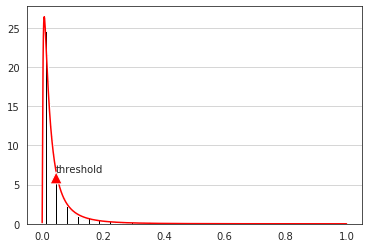

In [9]:
# Performing threshold graphcut
graph_mode = 'complete'

if graph_mode == 'complete':
    weights = nx.get_edge_attributes(graph_weighted, 'weight').values()
elif graph_mode == 'mst':
    # Compute Minimum Spanning Tree
    graph_mst = get_mst(graph_weighted)
    weights = nx.get_edge_attributes(graph_mst, 'weight').values()
    graph_weighted = graph_mst

    
cut_level = 0.7 
law_type = 'log'
thresh, params = fit_distribution_law(list(weights), cut_level, law_type)

x = np.linspace(0, max(weights), 1000)
if law_type == 'gamma':
    pdf_fitted = gamma.pdf(x, *params)
    thr_pos = gamma.pdf(thresh, *params)
elif law_type == 'log':
    pdf_fitted = lognorm.pdf(x, *params)
    thr_pos = lognorm.pdf(thresh, *params)
elif law_type == 'beta':
    pdf_fitted = beta.pdf(x, *params)
    thr_pos = beta.pdf(thresh, *params)

plt.figure()
plt.hist(weights, bins='auto', color='k', density=True)
plt.plot(x, pdf_fitted, color='r')
plt.grid(axis='y')
plt.annotate('threshold', xy=(thresh, thr_pos), xytext=(thresh, pdf_fitted.max()/4), arrowprops=dict(facecolor='red', shrink=2))


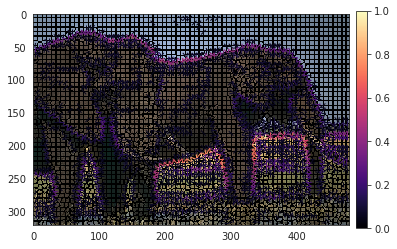

In [10]:
graph_aftercut_inverse = graph_weighted.copy()
to_remove = [(x, y) for x, y, d in graph_aftercut_inverse.edges(data=True)
                 if d['weight'] < thresh]
graph_aftercut_inverse.remove_edges_from(to_remove)

lc = graph.show_rag(regions_slic, graph_aftercut_inverse, superpixels, edge_width=1, img_cmap=None, border_color=None)
colbar_lim = (min(y_pred_norm), max(y_pred_norm))
lc.set_clim(colbar_lim[0], colbar_lim[1])
plt.colorbar(lc, fraction=0.0355, pad=0.02)
# plt.imshow(img)

Number of regions after graph cut: 183


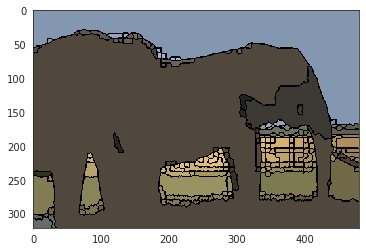

In [11]:
graph_aftercut = graph_weighted.copy()

graph.cut_threshold(regions_slic, graph_aftercut, thresh, in_place=True)
regions_aftercut = graph2regions(graph_aftercut, regions_slic)
weights_aftercut = nx.get_edge_attributes(graph_aftercut, 'weight').values()

plt.figure()
out = color.label2rgb(regions_aftercut, img, kind='avg')
out = segmentation.mark_boundaries(out, regions_aftercut, color=(0, 0, 0), mode='thick')
ax = plt.gca()
ax.imshow(out)

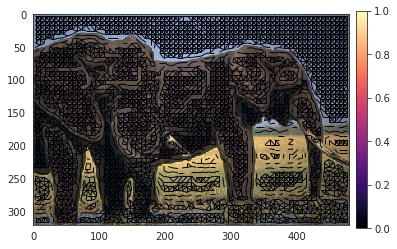

In [12]:
lc = graph.show_rag(regions_slic, graph_aftercut, img, edge_width=1, img_cmap=None, border_color=None)
colbar_lim = (min(y_pred_norm), max(y_pred_norm))
lc.set_clim(colbar_lim[0], colbar_lim[1])
plt.colorbar(lc, fraction=0.0355, pad=0.02)
plt.imshow(img) 

In [13]:
# # Generating superpixels graph
# graph_type = 'rag'
# graph_raw = get_graph(img, regions_aftercut, graph_type)

# lc = graph.show_rag(regions_aftercut, graph_raw, img, edge_width=1, img_cmap=None, border_color=None)
# colbar_lim = (0, 1)
# lc.set_clim(colbar_lim[0], colbar_lim[1])
# plt.colorbar(lc, fraction=0.0355, pad=0.02)
# plt.imshow(img)  

In [14]:
# # Reading Gabor features from h5 files

# hdf5_indir_feat = Path('../../data/hdf5_datasets/'+str(num_imgs)+'images/' + 'features/' + gabor_config)
# features_file = h5py.File(hdf5_indir_feat / 'Gabor_features.h5', "r+")
# feature_vectors = features_file["gabor_features"][test_indices][img_index]

# n_freq = features_file.attrs['num_freq']
# n_angles = features_file.attrs['num_angles']
# fb = features_file.attrs['frequency_bandwidth']

# g_energies = feature_vectors.reshape(rows, cols, n_freq * n_angles, channels)

# # Compute ground distance matrix
# ground_distance = cost_matrix_texture(n_freq, n_angles, fb)

In [15]:
# graph_lum = graph_raw.copy()
# graph_cr = graph_raw.copy()
# graph_ci = graph_raw.copy()

# ''' Updating edges weights with similarity measure (OT/KL) '''
# graph_weighted_lum = update_edges_weight(regions_aftercut, graph_lum, g_energies[:, :, :, 0], ground_distance, similarity_measure)
# graph_weighted_cr = update_edges_weight(regions_aftercut, graph_cr, g_energies[:, :, :, 1], ground_distance, similarity_measure)
# graph_weighted_ci = update_edges_weight(regions_aftercut, graph_ci, g_energies[:, :, :, 2], ground_distance, similarity_measure)

# weights_lum = np.fromiter(nx.get_edge_attributes(graph_weighted_lum, 'weight').values(), dtype=np.float32)
# weights_cr = np.fromiter(nx.get_edge_attributes(graph_weighted_cr, 'weight').values(), dtype=np.float32)
# weights_ci = np.fromiter(nx.get_edge_attributes(graph_weighted_ci, 'weight').values(), dtype=np.float32)

In [16]:
# lc = graph.show_rag(regions_aftercut, graph_weighted_lum, img, edge_width=1, img_cmap=None, border_color=None)
# colbar_lim = (min(weights_lum), max(weights_lum))
# lc.set_clim(colbar_lim[0], colbar_lim[1])
# plt.colorbar(lc, fraction=0.0355, pad=0.02)
# plt.imshow(img)  

In [17]:
# lc = graph.show_rag(regions_aftercut, graph_weighted_cr, img, edge_width=1, img_cmap=None, border_color=None)
# colbar_lim = (min(weights_cr), max(weights_cr))
# lc.set_clim(colbar_lim[0], colbar_lim[1])
# plt.colorbar(lc, fraction=0.0355, pad=0.02)
# plt.imshow(img)  

In [18]:
# lc = graph.show_rag(regions_aftercut, graph_weighted_ci, img, edge_width=1, img_cmap=None, border_color=None)
# colbar_lim = (min(weights_ci), max(weights_ci))
# lc.set_clim(colbar_lim[0], colbar_lim[1])
# plt.colorbar(lc, fraction=0.0355, pad=0.02)
# plt.imshow(img)  

In [19]:
# graph_lum_chr = graph_raw.copy()
# for i_edge, e in enumerate(list(graph_lum_chr.edges)):
#     total_weight = weights_lum[i_edge] + weights_cr[i_edge] + weights_ci[i_edge]
#     graph_lum_chr[e[0]][e[1]]['weight'] = total_weight
#     graph_lum_chr[e[0]][e[1]]['similarity'] = int(1.0/total_weight* 1e4)
    
# weights_lum_chr = np.fromiter(nx.get_edge_attributes(graph_lum_chr, 'weight').values(), dtype=np.float32)

In [20]:
# lc = graph.show_rag(regions_aftercut, graph_lum_chr, img, edge_width=1, img_cmap=None, border_color=None)
# colbar_lim = (min(weights_lum_chr), max(weights_lum_chr))
# lc.set_clim(colbar_lim[0], colbar_lim[1])
# plt.colorbar(lc, fraction=0.0355, pad=0.02)
# plt.imshow(img)  

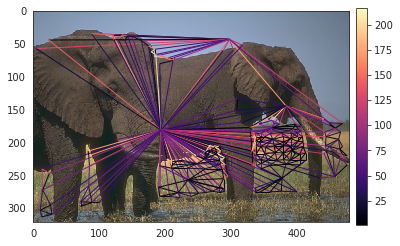

In [21]:
# Generating graph after the 1st cut 
graph_type = 'rag'
graph_mean_color = graph.rag_mean_color(img, regions_aftercut, mode='distance')

lc = graph.show_rag(regions_aftercut, graph_mean_color, img, edge_width=1, img_cmap=None, border_color=None)
colbar_lim = (None, None)
lc.set_clim(colbar_lim[0], colbar_lim[1])
plt.colorbar(lc, fraction=0.0355, pad=0.02)
plt.imshow(img)  

In [22]:
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])

In [23]:
labels2 = graph.merge_hierarchical(regions_aftercut, graph_mean_color, thresh=70, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

In [24]:
labels2.shape

(321, 481)

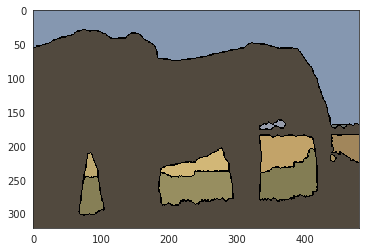

In [25]:
plt.figure()
out = color.label2rgb(labels2, img, kind='avg')
out = segmentation.mark_boundaries(out, labels2, color=(0, 0, 0), mode='thick')
ax = plt.gca()
ax.imshow(out)

In [26]:
for i_edge, e in enumerate(list(graph_mean_color.edges)):
    graph_mean_color[e[0]][e[1]]['similarity'] = graph_mean_color[e[0]][e[1]]['weight'] 
graph_mean_color.graph['edge_weight_attr'] = 'similarity'


In [27]:
graph_mean_color[0][1]['similarity']

KeyError: 0

In [ ]:
graph_mean_color[0][1]['weight']

In [ ]:
print(hola)

In [ ]:
# Preparing data for chameleon
centroids = nx.get_node_attributes(graph_mean_color, 'centroid').values()

for i, p in enumerate(graph_mean_color.nodes()):
    graph_mean_color.nodes[p]['cluster'] = graph_mean_color.nodes[p]['labels'][0]

df = pd.DataFrame.from_dict(centroids)

df['cluster'] = nx.get_node_attributes(graph_mean_color, 'cluster').values()

In [ ]:
init_clusters = int(len(centroids))
print(init_clusters)
final_clusters = 4
alpha = 2
iterm = tqdm(enumerate(range(init_clusters - final_clusters)), total=init_clusters - final_clusters)
for i in iterm:
    merge_best(graph_mean_color, df, alpha, final_clusters, verbose=False)
#     plot2d_data(df)

In [ ]:
res = rebuild_labels(df)
plot2d_data(res)

In [ ]:
map_array = np.zeros(regions_slic.max() + 1, dtype=regions_slic.dtype)
# Mapping from old labels to new
for n, d in graph_mean_color.nodes(data=True):
    map_array[d['labels']] = d['cluster']

In [ ]:
regions_cham = map_array[regions_slic]
out = color.label2rgb(regions_cham, img, kind='avg')
out = segmentation.mark_boundaries(out, regions_cham, color=(0, 0, 0), mode='thick')
ax = plt.gca()
ax.imshow(out)


In [ ]:
regions_cham = graph2regions(graph_mean_color, regions_slic)
# map_array = np.zeros(regions_aftercut.max() + 1, dtype=regions_aftercut.dtype)
# # Mapping from old labels to new
# for n, d in graph_mean_color.nodes(data=True):
#     map_array[d['labels']] = d['cluster']
    
# regions_cham = map_array[regions_aftercut]
out = color.label2rgb(regions_cham, img, kind='avg')
out = segmentation.mark_boundaries(out, regions_cham, color=(0, 0, 0), mode='thick')
ax = plt.gca()
ax.imshow(out)

In [ ]:
lc = graph.show_rag(regions_aftercut, graph_mean_color, img, edge_width=1, img_cmap=None, border_color=None)
# colbar_lim = (0, 1)
# lc.set_clim(colbar_lim[0], colbar_lim[1])
plt.colorbar(lc, fraction=0.0355, pad=0.02)
plt.imshow(img)  

In [ ]:
print(hola)

In [ ]:
centroids = nx.get_node_attributes(graph_pred, 'centroid').values()
df = pd.DataFrame.from_dict(centroids)


In [ ]:
# Dividing original graph using max number of nodes 
max_num_nodes = 40
num_clusters = 3
alpha = 1000
graph_parted = pre_part_graph(graph_pred, max_num_nodes, df, verbose=True)

In [ ]:
iterm = tqdm(enumerate(range(max_num_nodes - num_clusters)), total=max_num_nodes - num_clusters)
for i in iterm:
    merge_best(graph_parted, df, alpha, num_clusters, verbose=False)
#     plot2d_data(df)

In [ ]:
res = rebuild_labels(df)

In [ ]:
plot2d_data(res)

In [ ]:
map_array = np.zeros(regions_slic.max() + 1, dtype=regions_slic.dtype)
# Mapping from old labels to new
for n, d in graph_pred.nodes(data=True):
    map_array[d['labels']] = d['cluster']
    


In [ ]:
regions_cham = map_array[regions_slic]
out = color.label2rgb(regions_cham, img, kind='avg')
out = segmentation.mark_boundaries(out, regions_cham, color=(0, 0, 0), mode='thick')
ax = plt.gca()
ax.imshow(out)
